The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Generating images for dataset with 3000 samples
torch.Size([3, 1, 4]) torch.Size([3, 1]) torch.Size([3, 24, 24, 4])
tensor([[ 0.0000,  0.0000, -0.3271,  0.9450]])


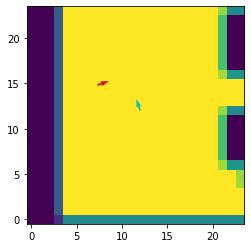

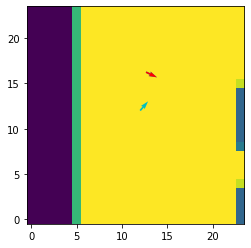

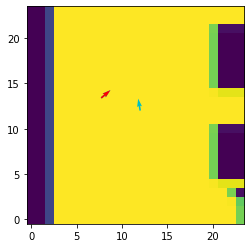

In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")

from torch.utils.tensorboard import SummaryWriter
from typing import List
import torch
import json
import numpy as np
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from genff.visualization.plotting import plot_sample_no_map_rect, plot_sample_on_full_map_rect, plot_sample_rect
from genff.gan_method.transform import RectangularAngle
from genff.gan_method.dataset import GroupDataset

from genff.data_handling.transform import TranslateToCentroid
from genff.visualization.plotting import plot_sample, plot_sample_on_full_map
from genff.data_handling.cocktail_gan import CocktailEnvGANDataset
from genff.gan_method.dataset import GroupDataset
from genff.metrics import *
from genff.eval.eval_helpers import compute_results, compute_generator_results
from genff.gan_method.networks import GenNet

def load_args(path):
    # save params
    with open(path, 'r') as fid:
        return json.load(fid)

def log_sample_images(generator: torch.nn.Module, dataset: Dataset, images_indices: List[int], device: torch.device = "cpu", num_samples: int = 20) -> None:
    """
    Helper function to log generated samples to tensorboard
    :param generator: generator model
    :param dataset: dataset with images
    :param images_indices: indices of the images to be plotted
    :param device: processing device
    :param num_samples: number of samples to generate per batch example
    """
    generator.eval()
    transform = RectangularAngle(2)

    with torch.no_grad():

        # make batch of images
        batch_size = len(images_indices)
        ind_list = []
        con_list = []
        mas_list = []
        env_list = []
        for i, ind in enumerate(images_indices):
            sample = dataset[ind]
            ind_list.append(sample[0])
            con_list.append(sample[1])
            mas_list.append(sample[2])
            env_list.append(sample[3])

        individual = torch.stack(ind_list).to(device=device)
        context = torch.stack(con_list).to(device=device)
        mask = torch.stack(mas_list).to(device=device)
        env = torch.stack(env_list).to(device=device)

        # transform batch to rect repr
        individual, context, mask, env = transform((individual, context, mask, env))

        # make storage for the fake samples
        num_features = individual.shape[-1]
        samples = torch.zeros((batch_size, num_samples, num_features), device="cpu")

        # generate samples
        for s in range(num_samples):
            new_ind = generator(context, mask, env)
            samples[:, s, :] = new_ind[:, 0, :].cpu()

        individual = individual.cpu()
        context = context.cpu()
        mask = mask.cpu()

        # plot data
        for b in range(batch_size):
            fig = plt.figure()
            plot_sample_rect(individual[b, :, :], context[b, :, :], mask[b, :], env_cropped=env[b,:,:,:],
                             env_res=dataset.env_dict["resolution"], ind_color="g", mode="free")
            plot_sample_rect(samples[b, :, :], context[b, :, :], mask[b, :], env_cropped=env[b,:,:,:],
                             env_res=dataset.env_dict["resolution"], ind_color="r", mode="free")
            plt.gca().set_aspect('equal')
            fig.savefig("../images/{}.png".format(b))
            

def log_sample_groups(generator: torch.nn.Module, dataset: Dataset, images_indices: List[int], 
                      add_size: int = 1, device: torch.device = "cpu", x_index: int = 0,
                      y_index: int = 1, theta_index: int = 2, cos_index: int = 2, sin_index: int = 3) -> None:
    """
    Helper function to log generated samples to tensorboard
    :param generator: generator model
    :param dataset: dataset with images
    :param images_indices: indices of the images to be plotted
    :param add_size: total size of additional generated people
    :param device: processing device
    """
    generator.eval()
    transform = RectangularAngle(2)

    with torch.no_grad():

        # make batch of images
        batch_size = len(images_indices)
        ind_list = []
        con_list = []
        mas_list = []
        env_list = []
        for i, ind in enumerate(images_indices):
            sample = dataset[ind]
            ind_list.append(sample[0])
            con_list.append(sample[1])
            mas_list.append(sample[2])
            env_list.append(sample[3])

        orig_individual = torch.stack(ind_list).to(device=device)
        orig_context = torch.stack(con_list).to(device=device)
        orig_mask = torch.stack(mas_list).to(device=device)
        orig_env = torch.stack(env_list).to(device=device)
        starting_size = orig_context.shape[1]
        
        def plot_group(batch_size, samples, orig_context, orig_mask, orig_env, size:int = 1):
            samples, context, mask, env = transform((samples, orig_context, orig_mask, orig_env))
            samples = samples.cpu()
            context = context.cpu()
            mask = mask.cpu()

            # plot data
            for b in range(batch_size):
                fig = plt.figure()
                plot_sample_rect(samples[b, :, :], context[b, :, :], 
                                 mask[b, :], env_cropped=env[b,:,:,:], env_res=dataset.env_dict["resolution"], 
                                 ind_color="r", mode="free")
                plt.gca().set_aspect('equal')
                fig.savefig("../images/{}_group_size{}.png".format(b, size))

        # transform batch to rect repr
        for i in range(add_size):
            individual, context, mask, env = transform((orig_individual, orig_context, orig_mask, orig_env))

            print(context.shape, mask.shape, env.shape)
            # make storage for the fake samples
            num_features = individual.shape[-1]
            samples = torch.zeros((batch_size, 1, num_features-1), device="cpu")

            print(context[0])
            new_ind = generator(context, mask, env)
            samples[:, 0, [x_index,y_index]] = new_ind[:, 0, [x_index,y_index]].cpu()
            norm = torch.sqrt(torch.pow(new_ind[:, 0, [cos_index]].cpu(),2) + torch.pow(new_ind[:, 0, [sin_index]].cpu(),2))
            samples[:, 0, [theta_index]] = torch.atan(new_ind[:, 0, [sin_index]].cpu() / new_ind[:, 0, [cos_index]].cpu())
            
            orig_context = torch.cat((orig_context, samples), dim=1)
            orig_mask = torch.cat((mask, torch.ones(batch_size, 1)), dim=1)
            plot_group(batch_size, samples, orig_context, orig_mask, orig_env, i+starting_size+1)

            

dataset = GroupDataset("../data/simulated/gen_group_output_data.txt", 
                       "../data/simulated/gen_group_env_images.npz",
                       notebook=True)
print("Generating images for dataset with {} samples".format(len(dataset)))

stamp = "20201103_104001"
iteration = 251
model_path = "../logs/{}/{}_{}.pt".format(stamp,stamp,iteration)
args_path = "../logs/{}/args.txt".format(stamp)
args = load_args(args_path)
generator = GenNet(args["grid_res"], args["grid_w"], args["grid_w"], sigma=args["plot_sigma"])
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
generator.load_state_dict(checkpoint['generator_state_dict'])
# log_sample_images(generator, dataset, np.random.choice([x for x in range(len(dataset))], 20, replace=False))
log_sample_groups(generator, dataset, np.random.choice([x for x in range(len(dataset))], 3, replace=False))


